# Imports

In [2]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  print('Error Initialising Iminuit')

In [3]:
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.axis import Axis

# Funzioni

In [23]:
def sturges(data):
  return int(1 + np.log2(len(data)))

In [4]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [5]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [6]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [7]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Dati

In [61]:
data = 'https://docs.google.com/spreadsheets/d/11Db4q9pAoPY3wLuFJ6OIKQspeL21LUiSDEYFjaHlQyw/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['Rv', 'Ra', 'Ra2 ', 'Ohm', 'Serie', 'Parallelo', 'Partitore', 'Diodo'])


In [62]:
def R_parall(R1,R2):
  return (R1*R2)/(R1+R2)

# Rv

In [17]:
RV_dati = df['Rv']
# print(RV_dati)

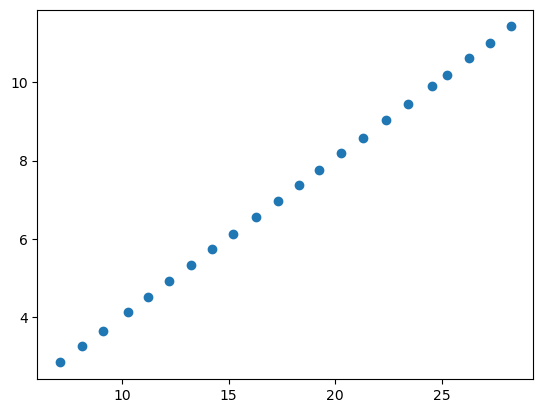

In [18]:
V_rv = RV_dati['V']
I_rv = RV_dati['I [micro A]']
plt.scatter(V_rv,I_rv)

In [24]:
def ohm_law(V, R):
  return V/R

In [26]:
c = LeastSquares(V_rv, I_rv, 0.01, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.83 (χ²/ndof = 1.3)      │              Nfcn = 30               │
│ EDM = 4.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  2.4768   │  0.0007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       R │
├───┼─────────┤
│ R │ 4.8e-07 │
└───┴─────────┘

In [31]:
R2 = 3.272
Req = m.values['R']

print(R2*Req/(R2-Req))

10.190484353080327


# Ra

In [52]:
RA_dati = df['Ra']
# print(RA_dati)

In [57]:
c = LeastSquares(RA_dati['V'][:8], RA_dati['I [mA]'][:8]*1e-3, 0.0001, ohm_law)
m = Minuit(c, R=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.02155 (χ²/ndof = 0.0)    │              Nfcn = 73               │
│ EDM = 7.41e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │   110.2   │    1.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────┐
│   │    R │
├───┼──────┤
│ R │ 1.96 │
└───┴──────┘

In [56]:
c = LeastSquares(RA_dati['V'][8:], RA_dati['I [mA]'][8:]*1e-3, 0.001, ohm_law)
m = Minuit(c, R=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.022 (χ²/ndof = 0.1)      │              Nfcn = 52               │
│ EDM = 2.03e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  11.445   │   0.018   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 0.000313 │
└───┴──────────┘

In [53]:
RA = m.values['R']-9.9
print(RA)

1.545616878823889


# Legge Ohm


In [66]:
Ohm = df['Ohm']
print(Ohm.keys())

Index(['Unnamed: 0', 'Resistenza kΩ', 'V 1', 'Ι [μA] 1', 'Unnamed: 4', 'V 2',
       'I [μA] 2', 'Unnamed: 7'],
      dtype='object')


## Configurazione 1

In [70]:
c = LeastSquares(Ohm['V 1'], Ohm['Ι [μA] 1']*1e-6, 1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.005268 (χ²/ndof = 0.0)   │              Nfcn = 150              │
│ EDM = 5.08e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  147.5e3  │   1.9e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 3.62e+06 │
└───┴──────────┘

0.06427711012361824


0.9505466382893668

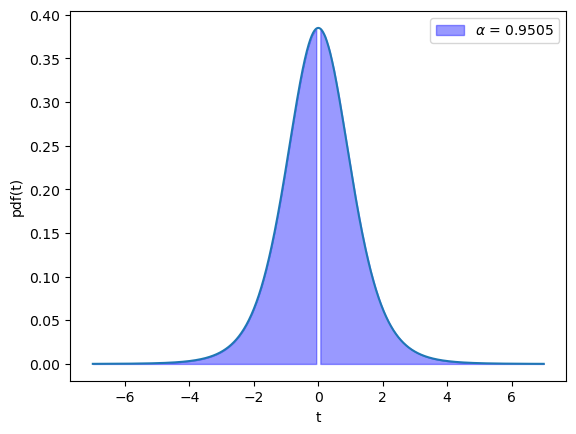

In [75]:
t = abs(m.values['R']-150e3)/np.sqrt((m.errors['R']**2)/7 + (7.5e3)**2)
print(t)
t_test(t, 7)

## Configurazione 2

In [72]:
c = LeastSquares(Ohm['V 2'], Ohm['I [μA] 2']*1e-6, 1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.002008 (χ²/ndof = 0.0)   │              Nfcn = 150              │
│ EDM = 1.84e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  149.5e3  │   1.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 2.06e+06 │
└───┴──────────┘

# R Serie

# R //

# Diodo 

In [10]:
def shockley(Io, V):+
    
  q = 1.6e19
  k = 1.38e23
  T = 300
  return Io*(np.exp(V*q/(g*k*T))-1)

SyntaxError: invalid syntax (3479968804.py, line 1)